In [20]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasRegressor

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [21]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [22]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('nasdaq2000~2023.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000/1/3,4186.189941,4192.189941,3989.709961,4131.149902,4131.149902,1510070000
1,2000/1/4,4020.000000,4073.250000,3898.229980,3901.689941,3901.689941,1511840000
2,2000/1/5,3854.350098,3924.209961,3734.870117,3877.540039,3877.540039,1735670000
3,2000/1/6,3834.439941,3868.760010,3715.620117,3727.129883,3727.129883,1598320000
4,2000/1/7,3711.090088,3882.669922,3711.090088,3882.620117,3882.620117,1634930000
...,...,...,...,...,...,...,...
5883,2023/5/22,12664.440430,12756.230470,12655.259770,12720.780270,12720.780270,4278920000
5884,2023/5/23,12652.879880,12709.740230,12554.429690,12560.250000,12560.250000,4347440000
5885,2023/5/24,12481.889650,12529.629880,12415.849610,12484.160160,12484.160160,359790000
5886,2023/5/25,12706.440430,12736.919920,12604.889650,12698.089840,12698.089840,4651640000


In [23]:
new_df=df.iloc[:,[0,4]].copy()
new_df.head()

,Date,Close
0,2000/1/3,4131.149902
1,2000/1/4,3901.689941
2,2000/1/5,3877.540039
3,2000/1/6,3727.129883
4,2000/1/7,3882.620117


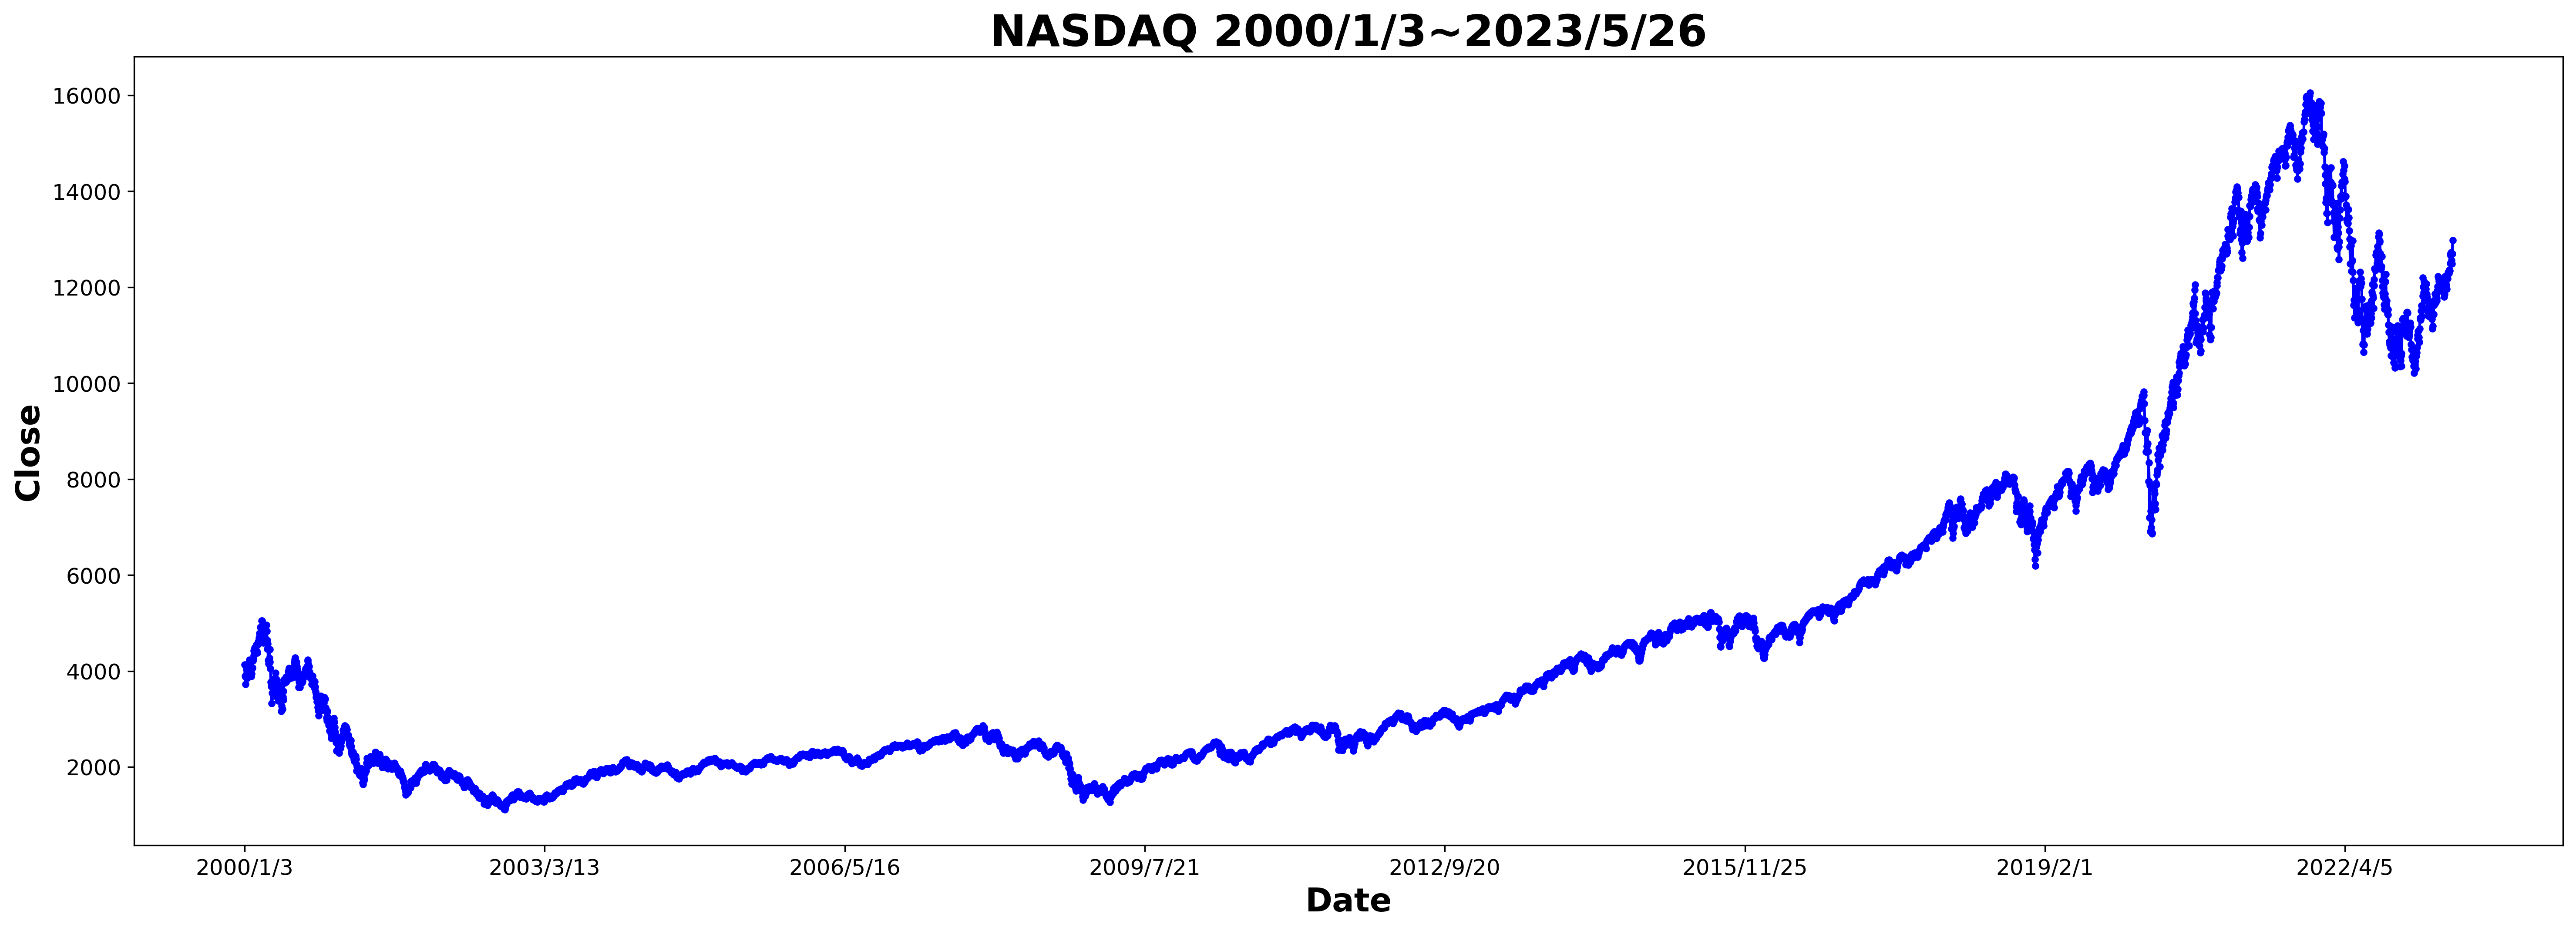

In [24]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('NASDAQ 2000/1/3~2023/5/26',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(df['Date'][::800],fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [25]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000/1/3,4131.149902,NaN,NaN,NaN
1,2000/1/4,3901.689941,4131.149902,NaN,NaN
2,2000/1/5,3877.540039,3901.689941,4131.149902,NaN
3,2000/1/6,3727.129883,3877.540039,3901.689941,4131.149902
4,2000/1/7,3882.620117,3727.129883,3877.540039,3901.689941


In [26]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000/1/6,3727.129883,3877.540039,3901.689941,4131.149902
1,2000/1/7,3882.620117,3727.129883,3877.540039,3901.689941
2,2000/1/10,4049.669922,3882.620117,3727.129883,3877.540039
3,2000/1/11,3921.189941,4049.669922,3882.620117,3727.129883
4,2000/1/12,3850.020020,3921.189941,4049.669922,3882.620117
...,...,...,...,...,...
5880,2023/5/22,12720.780270,12657.900390,12688.839840,12500.570310
5881,2023/5/23,12560.250000,12720.780270,12657.900390,12688.839840
5882,2023/5/24,12484.160160,12560.250000,12720.780270,12657.900390
5883,2023/5/25,12698.089840,12484.160160,12560.250000,12720.780270


In [27]:
x = clean_df.drop(['Date', 'Close'],axis=1).copy()
x.head()

,Lag_1,Lag_2,Lag_3
0,3877.540039,3901.689941,4131.149902
1,3727.129883,3877.540039,3901.689941
2,3882.620117,3727.129883,3877.540039
3,4049.669922,3882.620117,3727.129883
4,3921.189941,4049.669922,3882.620117


In [28]:
y = clean_df['Close'].copy()
y.head()

0    3727.129883
1    3882.620117
2    4049.669922
3    3921.189941
4    3850.020020
Name: Close, dtype: float64

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=False)

In [30]:
x_train_tuning, x_valid, y_train_tuning, y_valid = train_test_split(x_train,y_train,test_size=0.2,shuffle=False)

In [31]:
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train_tuning)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']
scaled_x_train

,Lag_1,Lag_2,Lag_3
0,0.702357,0.708495,0.766815
1,0.664128,0.702357,0.708495
2,0.703648,0.664128,0.702357
3,0.746106,0.703648,0.664128
4,0.713451,0.746106,0.703648
...,...,...,...
3761,0.897240,0.872719,0.887290
3762,0.923696,0.897240,0.872719
3763,0.928011,0.923696,0.897240
3764,0.932088,0.928011,0.923696


In [32]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

In [35]:
def create_model(learning_rate=0.01):
    # 6.1 Create the model
    clear.clear_session()
    model=Sequential()

    # 6.2 Add input layer & first hidden layer
    model.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1], 1)))

    # 6.3 Add second hidden layer
    model.add(LSTM(units=25, return_sequences = True, input_shape = (x_train.shape[1], 1)))

    model.add(Dropout(rate=0.2))

    # 6.4 Add third hidden layer
    model.add(LSTM(units=50))
    
    # 6.5 Add output layer
    model.add(Dense(units=1, activation='linear'))

    # 6.6 Compile the defined Net
    #opt=SGD(learning_rate=0.001,momentum=0.5)
    opt=Adam(learning_rate=learning_rate,beta_1=0.9)
    model.compile(loss='MSE',optimizer=opt, metrics=['mean_absolute_percentage_error'])

    # Finally check the model 
    return model

model = KerasRegressor(build_fn=create_model, epochs=100,verbose=0)
cv_inner = TimeSeriesSplit(n_splits=3)
learning_rate = [0.01,0.001,0.0001]
batch_size = [32,64]
param_grid = dict(batch_size=batch_size,learning_rate=learning_rate)
grid = GridSearchCV(estimator=model,param_grid=param_grid,cv=cv_inner,scoring='neg_root_mean_squared_error',n_jobs=-1)
grid_result = grid.fit(x_train, y_train)

print("Best:%fusing%s"%(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\kevin\AppData\Local\Temp\ipykernel_2720\1242624494.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=100,verbose=0)


Best:-1612.123602using{'batch_size': 32, 'learning_rate': 0.01}
-1612.123602 (1192.789509) with: {'batch_size': 32, 'learning_rate': 0.01}
-3185.765306 (1340.301800) with: {'batch_size': 32, 'learning_rate': 0.001}
-3512.182302 (1462.472448) with: {'batch_size': 32, 'learning_rate': 0.0001}
-2086.581539 (1037.093027) with: {'batch_size': 64, 'learning_rate': 0.01}
-3363.862514 (1406.854085) with: {'batch_size': 64, 'learning_rate': 0.001}
-3529.408687 (1469.575905) with: {'batch_size': 64, 'learning_rate': 0.0001}


In [36]:
train_data=clean_df.iloc[0:4704,:].copy()
train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,2000/1/6,3727.129883,3877.540039,3901.689941,4131.149902
1,2000/1/7,3882.620117,3727.129883,3877.540039,3901.689941
2,2000/1/10,4049.669922,3882.620117,3727.129883,3877.540039
3,2000/1/11,3921.189941,4049.669922,3882.620117,3727.129883
4,2000/1/12,3850.020020,3921.189941,4049.669922,3882.620117
...,...,...,...,...,...
4699,2018/9/11,7972.470215,7924.160156,7902.540039,7922.729980
4700,2018/9/12,7954.229980,7972.470215,7924.160156,7902.540039
4701,2018/9/13,8013.709961,7954.229980,7972.470215,7924.160156
4702,2018/9/14,8010.040039,8013.709961,7954.229980,7972.470215


In [37]:
test_data=clean_df.iloc[4704:5884,:].copy()
test_data

,Date,Close,Lag_1,Lag_2,Lag_3
4704,2018/9/18,7956.109863,7895.790039,8010.040039,8013.709961
4705,2018/9/19,7950.040039,7956.109863,7895.790039,8010.040039
4706,2018/9/20,8028.229980,7950.040039,7956.109863,7895.790039
4707,2018/9/21,7986.959961,8028.229980,7950.040039,7956.109863
4708,2018/9/24,7993.250000,7986.959961,8028.229980,7950.040039
...,...,...,...,...,...
5879,2023/5/19,12657.900390,12688.839840,12500.570310,12343.049810
5880,2023/5/22,12720.780270,12657.900390,12688.839840,12500.570310
5881,2023/5/23,12560.250000,12720.780270,12657.900390,12688.839840
5882,2023/5/24,12484.160160,12560.250000,12720.780270,12657.900390


In [38]:
new_train_data = clean_df.drop(['Date', 'Close'],axis=1).copy()
new_test_data = clean_df['Close'].copy()

In [39]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))
Fmodel.add(Dense(units=48, activation='linear'))
Fmodel.add(Dense(units=96, activation='relu'))
# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.01,beta_1=0.9)
Fmodel.compile(loss='MSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 96)                4704      
                                                                 
 dense_5 (Dense)             (None, 1)                 97        
                                                                 
Total params: 6,421
Trainable params: 6,421
Non-trainabl

In [40]:
history=Fmodel.fit(new_train_data, new_test_data, epochs=100, batch_size=32,verbose=1)

Epoch 1/100
184/184 [==============================] - 1s 1ms/step - loss: 438562.8750 - mean_absolute_percentage_error: 4.4508
Epoch 2/100
184/184 [==============================] - 0s 1ms/step - loss: 22505.8164 - mean_absolute_percentage_error: 1.9555
Epoch 3/100
184/184 [==============================] - 0s 1ms/step - loss: 23235.8789 - mean_absolute_percentage_error: 2.0705
Epoch 4/100
184/184 [==============================] - 0s 1ms/step - loss: 32788.0391 - mean_absolute_percentage_error: 2.4310
Epoch 5/100
184/184 [==============================] - 0s 2ms/step - loss: 30616.7402 - mean_absolute_percentage_error: 2.2874
Epoch 6/100
184/184 [==============================] - 0s 1ms/step - loss: 12828.5576 - mean_absolute_percentage_error: 1.5131
Epoch 7/100
184/184 [==============================] - 0s 1ms/step - loss: 24435.6289 - mean_absolute_percentage_error: 2.0746
Epoch 8/100
184/184 [==============================] - 0s 1ms/step - loss: 49017.5664 - mean_absolute_percenta

184/184 [==============================] - 0s 1ms/step - loss: 17283.2715 - mean_absolute_percentage_error: 1.7669
Epoch 66/100
184/184 [==============================] - 0s 1ms/step - loss: 14994.0381 - mean_absolute_percentage_error: 1.6315
Epoch 67/100
184/184 [==============================] - 0s 1ms/step - loss: 17809.8203 - mean_absolute_percentage_error: 1.8182
Epoch 68/100
184/184 [==============================] - 0s 1ms/step - loss: 15822.4180 - mean_absolute_percentage_error: 1.6796
Epoch 69/100
184/184 [==============================] - 0s 1ms/step - loss: 19064.9766 - mean_absolute_percentage_error: 1.8610
Epoch 70/100
184/184 [==============================] - 0s 1ms/step - loss: 11268.3154 - mean_absolute_percentage_error: 1.4033
Epoch 71/100
184/184 [==============================] - 0s 1ms/step - loss: 77851.6875 - mean_absolute_percentage_error: 3.0079
Epoch 72/100
184/184 [==============================] - 0s 1ms/step - loss: 11701.3711 - mean_absolute_percentage_err

In [41]:
Fmodel.save('House_Rent_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [42]:
ANN_model=keras.models.load_model('House_Rent_ANN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


In [43]:
# X test
x_forecast_test=test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=test_data['Close'].copy()

In [44]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [45]:
Results=pd.DataFrame({'Date':test_data['Date'],'Close_true':test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Close_true']-Results['Predict'])
Results

,Date,Close_true,Predict,abs Error
4704,2018/9/18,7956.109863,7826.049805,130.060058
4705,2018/9/19,7950.040039,7844.450195,105.589844
4706,2018/9/20,8028.229980,7854.089844,174.140136
4707,2018/9/21,7986.959961,7911.430176,75.529785
4708,2018/9/24,7993.250000,7898.850098,94.399902
...,...,...,...,...
5879,2023/5/19,12657.900390,12487.879883,170.020507
5880,2023/5/22,12720.780270,12509.030273,211.749997
5881,2023/5/23,12560.250000,12549.040039,11.209961
5882,2023/5/24,12484.160160,12443.200195,40.959965


In [46]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 185.671
MSE: 51461.587
RMSE: 226.851
MAPE: 1.705 %
SMAPE: 1.721 %
RAE: 0.083
MRAE: 7.005734841077867e-05
MdRAE: 0.074 bench: 10996.877
RSE: 0.008
RRSE: 0.087


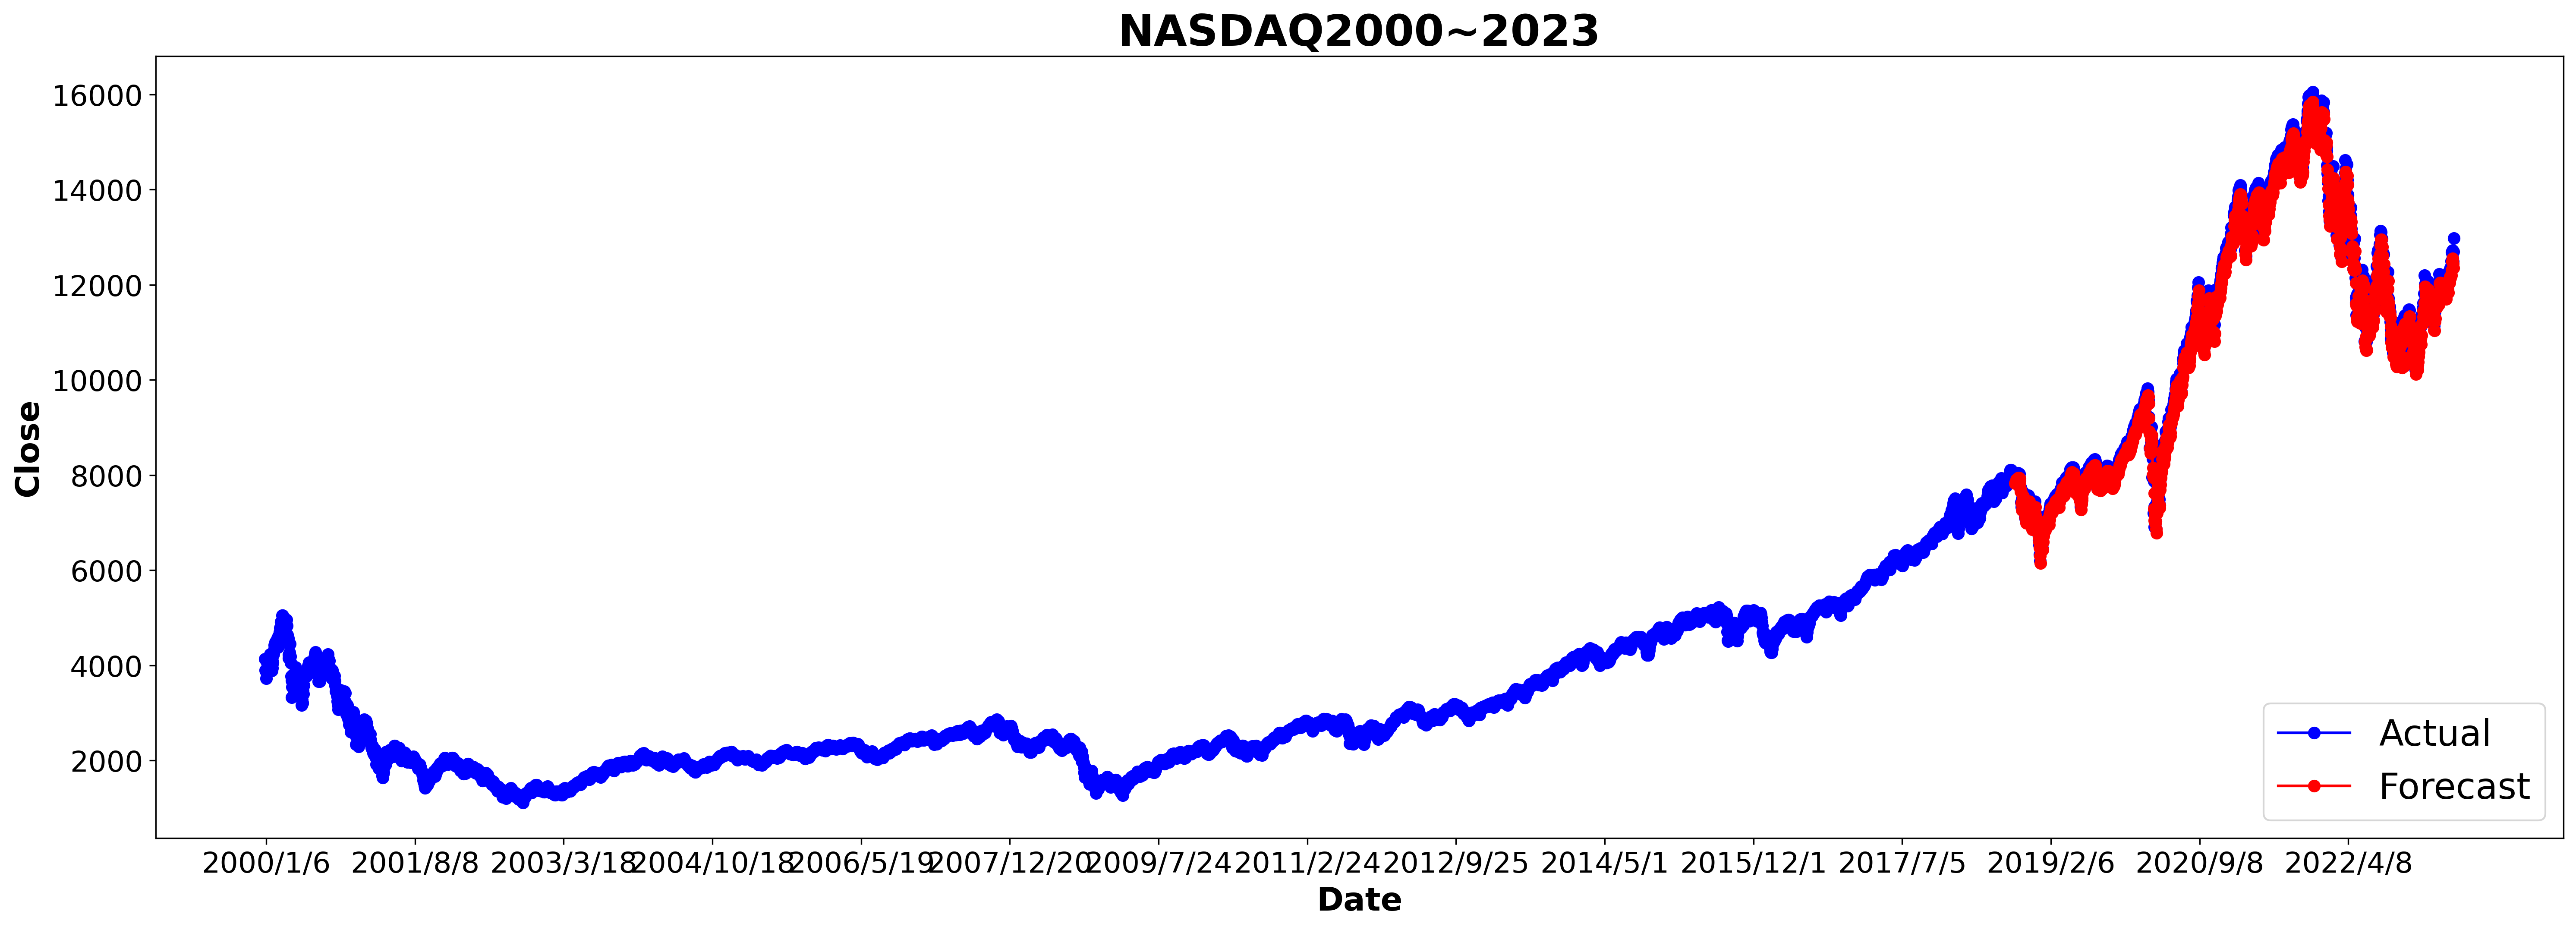

In [47]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('NASDAQ2000~2023',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(new_df['Date'],new_df['Close'],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(clean_df['Date'][::400], fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

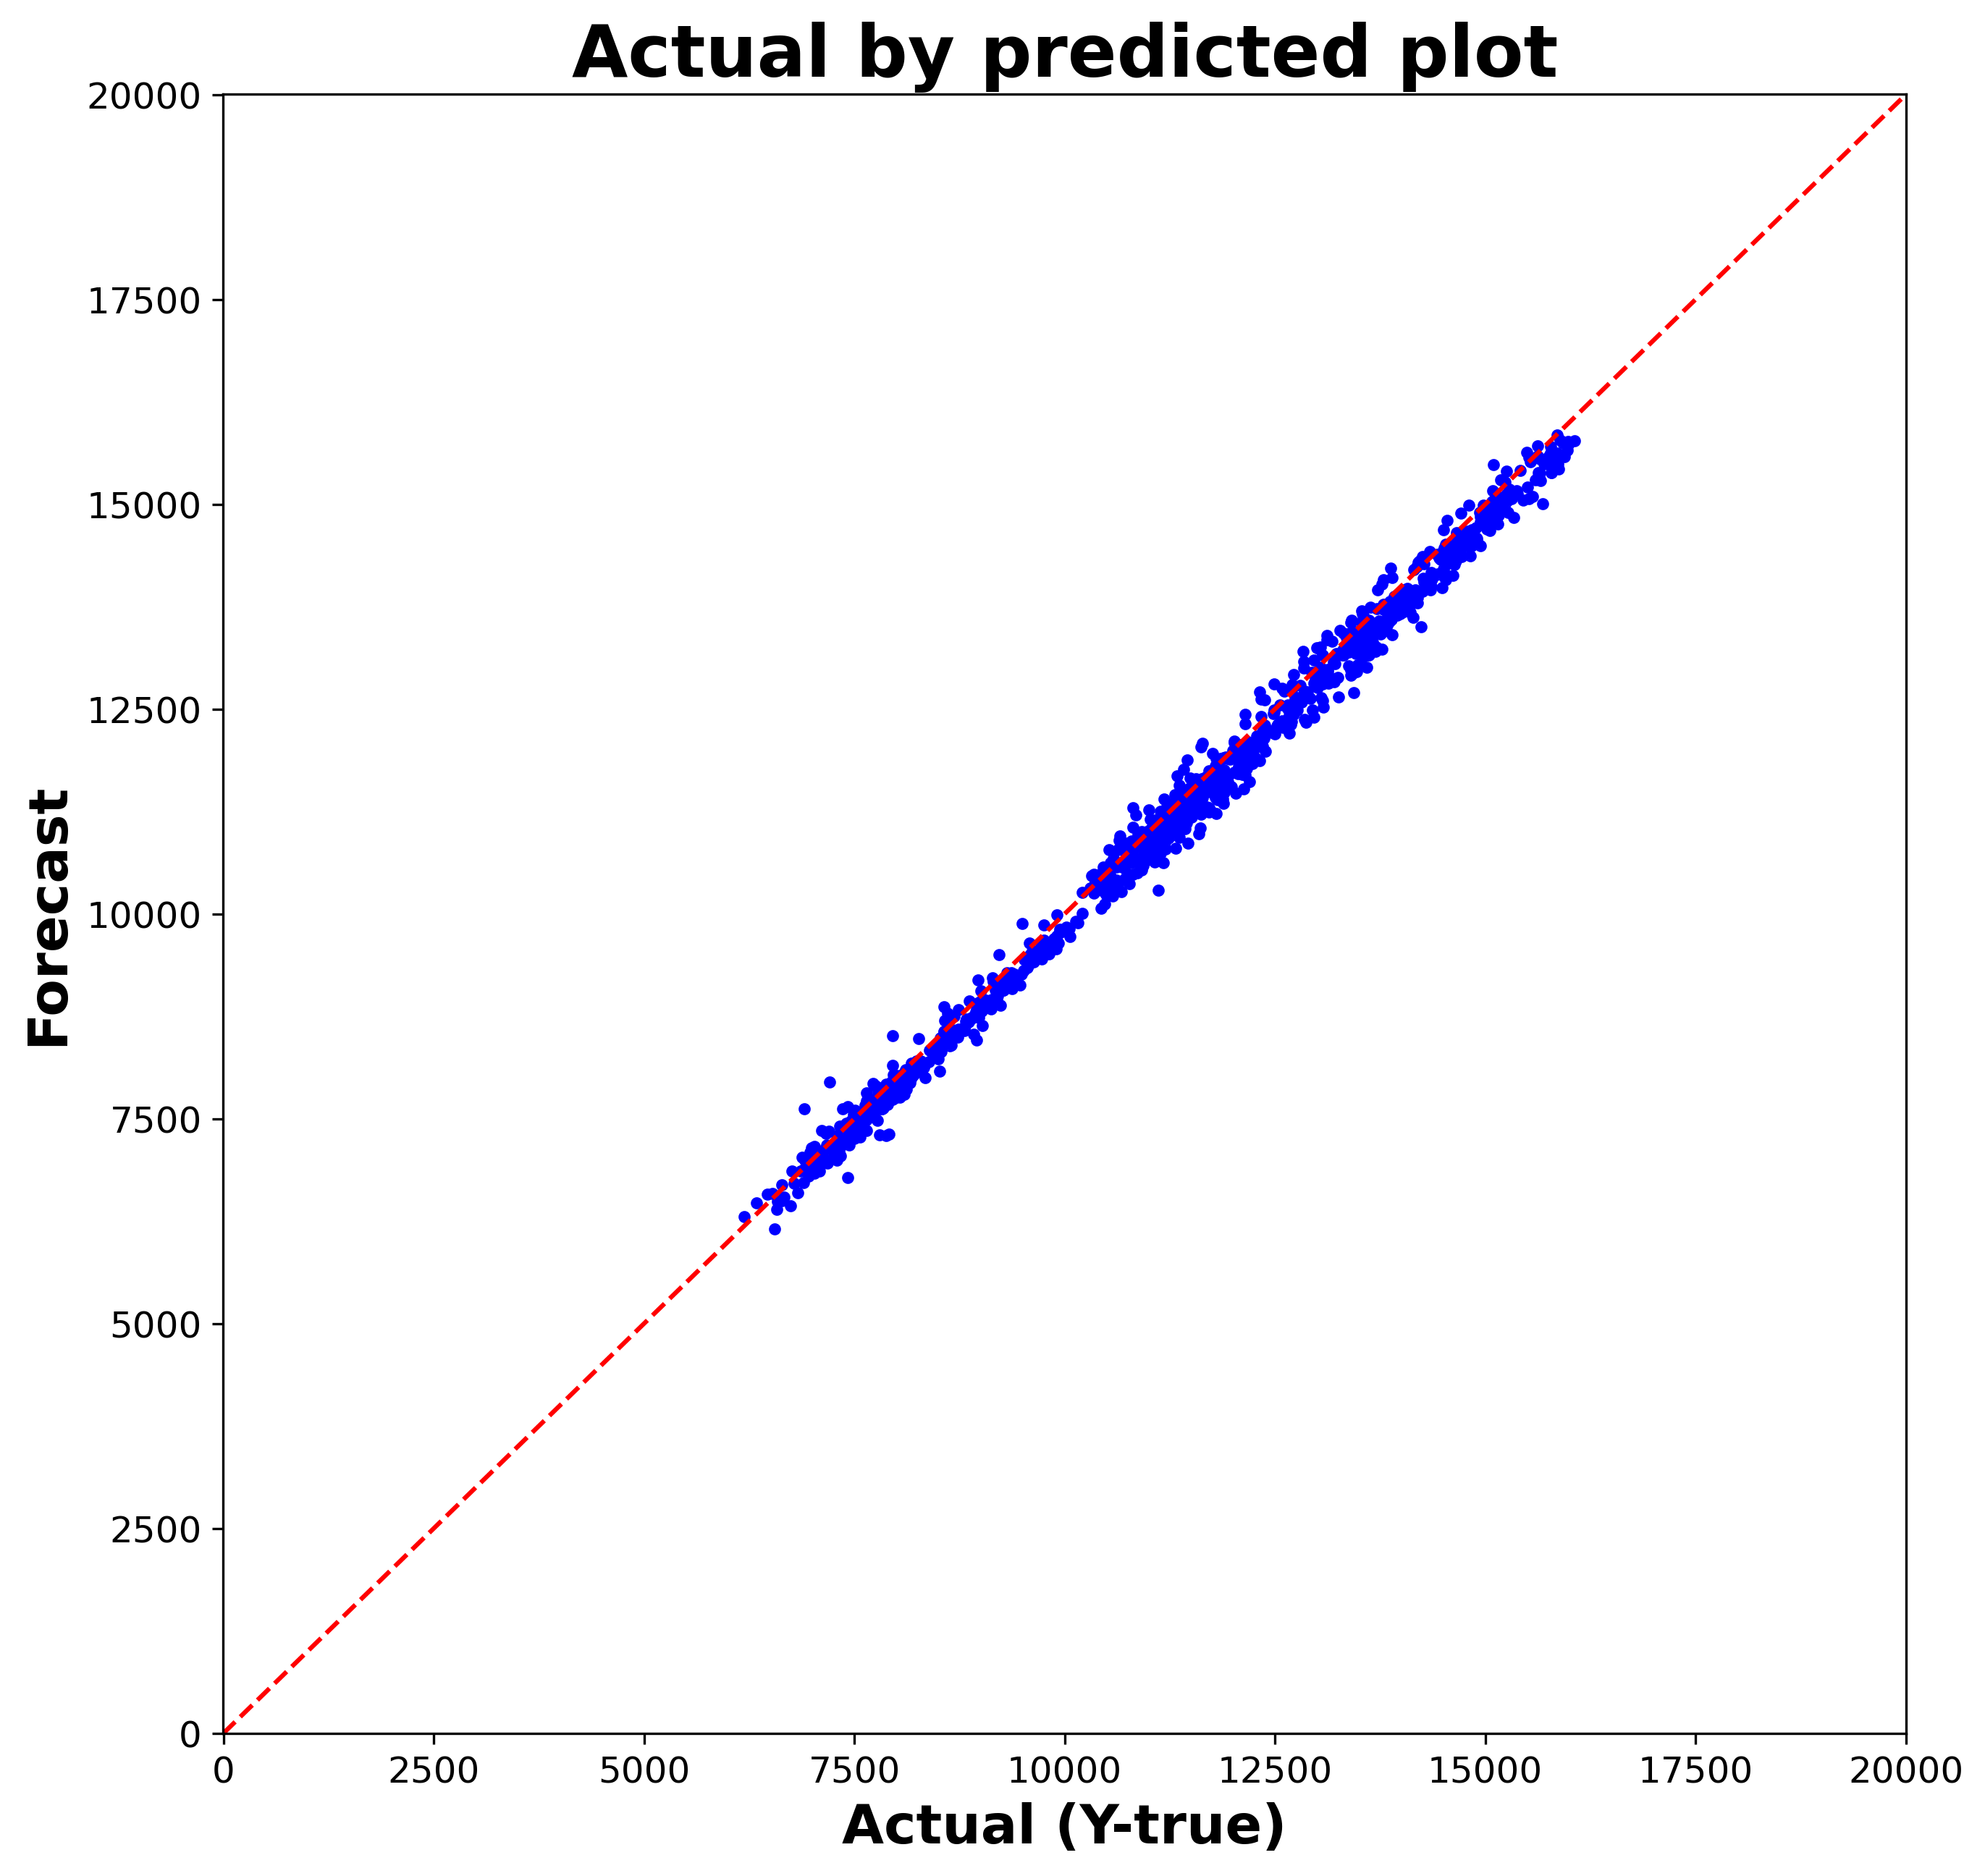

In [48]:
# Lock the scale of axis by Y_true
max_value=20000+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()